<h1>Libraries and Classes</h1>

Statistical Algorithm for the Research and Analysis of Heart Signals

SARAH  V-0.01   26/12/2021

Last revision   12/01/2022

Developed by:   J. Fuentes

In [2]:
# My library
import SARAH as sa

# Basic libraries
import h5py
import numpy as np
import pyedflib as edf
import pandas as pd

# Plots
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation

mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['text.latex.preamble'] = r"\usepackage{bm} \usepackage{amsmath}"

%matplotlib widget

# Auxiliar plots
from matplotlib.patches import Ellipse

# Scipy package for data fitting
from scipy.optimize import curve_fit

<h1>Open EDF</h1>

In [4]:
"""

    Signals and their respective channels in this file are listed as follows:
    
    ------------------------
     SIGNAL         CHANNEL
    ------------------------
     'SaO2'             0
     'H.R.'             1
     'EEG(sec)'         2
     'ECG'              3
     'EMG'              4
     'EOG(L)'           5
     'EOG(R)'           6
     'EEG'              7
     'THOR RES'         8
     'ABDO RES'         9
     'POSITION'        10
     'LIGHT'           11 
     'AIRFLOW'         12
     'OX stat          13
     ------------------------
     
"""
# Patient number
patient = "200003"

# Set path accordingly
path = "../polysomnography/edfs/shhs1/shhs1-"

# Open file
file = edf.EdfReader(path + patient + ".edf")

# Display data
print("The signals in this file correspond to", 
      file.getFileDuration() / 3600, 
      "hours of recorded data")

# Extract data
chn = 3
ECG = file.readSignal(chn)

# Original sampling frequency
f0 = int(file.samplefrequency(chn))

"""
    TO DO: if the signal is negative, it must be corrected,
    in any case there should be a routine to detect negative/positive signals
"""
# Filter ECG signal via Butterworth
ECG = -sa.filterECG(ECG, sampling_rate=f0)

# Close file once signals are read
file.close()

The signals in this file correspond to 8.741666666666667 hours of recorded data


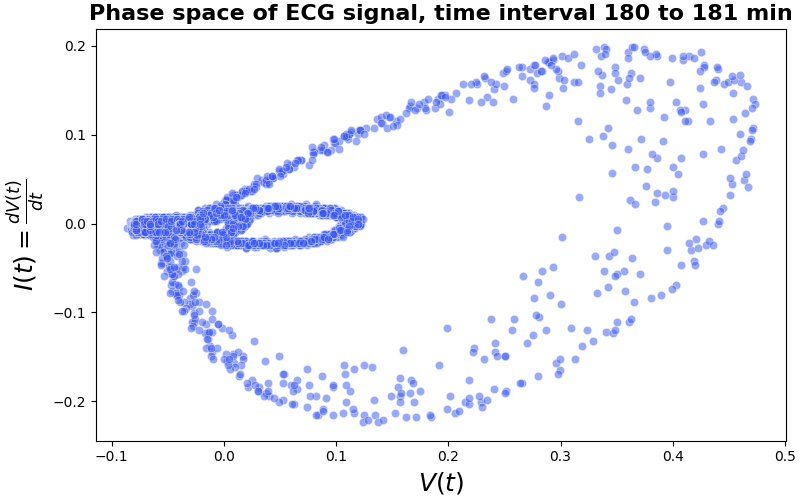

In [5]:
m = 180
ecg = ECG[m*60*f0:(m+1)*60*f0]

decg = np.ediff1d(ecg, to_begin=0)
ddecg = np.ediff1d(decg, to_begin=0)

plt.close()
fig = plt.figure(figsize=(8, 5), constrained_layout=True)

sns.scatterplot(x=ecg, y=decg, color='#3554F7', alpha=0.5)

# Plot parameters
plt.xlabel(r'$V(t)$', fontsize=18)
plt.ylabel(r'$I(t) = \frac{dV(t)}{dt}$', fontsize=18)
plt.title('Phase space of ECG signal, time interval ' 
          + str(m) + ' to ' + str(m+1) + ' min', 
          weight='bold',
          fontsize=16)

plt.savefig('phasespace-ECG-' + str(m) + '_' + str(m+1) + '.pdf', format='pdf')

plt.show()

<h1>Calling main function</h1>

In [4]:
"""
    Parameters:
    
    ecgstats(ecg,
             sampling_rate,
             start,             # In seconds
             time_width,        # In minutes (Typically: 1, 5, 10, 15, 30)
             n_iterations=None, # Set None for a complete scanning
             patient,
             getrpeaks=False,   # For debugging -->
             showdata=False,
             bandwidth=2)
"""
sa.controlpanel(ECG, f0, 0, 5, 1, patient)

>> Status:  5  out of  5  minutes of ECG signal analised


<h1>Read processed data to calculate statistics</h1>

In [ ]:
# Open h5 file as pandas df
dist = pd.HDFStore('patient-200003-width-5/200003-t_width-5-dists.h5')
peak = pd.HDFStore('patient-200003-width-5/200003-t_width-5-peaks.h5')
#data = pd.HDFStore('debug-t_width-5.h5')

# P, R and T distributions
rdists = []
pdists = []
tdists = []
for n in range( len(dist.keys()) ):
    rdists.append( dist['df'+str(n)]['R_t'] )
    pdists.append( dist['df'+str(n)]['P_t'] )
    tdists.append( dist['df'+str(n)]['T_t'] )

# P, R and T distributions
rpeaks = []
ppeaks = []
tpeaks = []
for n in range( len(peak.keys()) ):
    rpeaks.append( peak['df'+str(n)]['R'] )
    ppeaks.append( peak['df'+str(n)]['P'] )
    tpeaks.append( peak['df'+str(n)]['T'] )

# Redefine x-domain and ticks
rngb = np.arange(1, 50) / 20
xdom = np.linspace(np.min(rngb), np.max(rngb), num=500) # could be generalised

dist.close()
peak.close()

<h2>Dynamical analysis</h2>

In [ ]:
n = 30
sa.diagrams(xdom, rpeaks, rdists, f0, n, 'R-R distributions')

<h2>Animation of phase plots</h2>

In [ ]:
dens = rdists[n]
velo = np.diff(dens)
acce = np.diff(velo)
velo = np.append(velo, [0])
acce = np.append(acce, [0, 0])

# Function for updating line
def update_line(num, data, line):
    line.set_data(data[..., :num])
    return line,

# Define new figure
fig = plt.figure(figsize=(6, 6), constrained_layout=True)

# Stack data
data = np.vstack((velo, acce))
l, = plt.plot([], [], '.-', lw=2, color='#FF8289', alpha=0.4)

# Plot parameters
plt.xlim(np.min(velo), np.max(velo))
plt.ylim(np.min(acce), np.max(acce))
plt.xlabel('velocity', fontsize=18)
plt.ylabel('acceleration', fontsize=18)

line_ani = animation.FuncAnimation(fig, update_line, 
                                   frames=1000, fargs=(data, l), interval=20, blit=False)

plt.show()